## Problem 1

###  Fitting a Line using a Maximum Likelihood Estimator

Last week, you implcitly fitted straight lines with methods of moments estimators (i.e. sample mean and variance) and L-estimators (median and IQR). Generally though, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by a gaussian process. I.e.:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$

>$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

This is the expression that we now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


And as we discussed in class, this is equivalent to minimizing the sum of the squares or a _least-squares method_.

## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:


- Fit a line to the full sample by evaluating the squared loss likelihood (see the squared_loss function) on a grid of a, b
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected
- Define a new likelihood function that implements the Huber loss (huber_loss, https://en.wikipedia.org/wiki/Huber_loss), also incorporating the measurement uncertainties $dy$
- Fit a new line to all of the data (no outlier rejection) with the new Huber likelihood, except now use scipy.optimize.fmin instead of a grid search.

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

## A1:

In [5]:
# define a straight line
def line(a, b, x):
    return a*x + b

def zres(a, b, x, y, dy):
    z = (y - line(a, b, x))/dy
    return z
    
# Define a standard squared-loss function
def squared_loss(a, b, x, y, dy):
    # we'll add the extra 1/2 just to make the scaling the same as the Huber loss - just a constant
    z = zres(a, b, x, y, dy)
    return np.sum(z**2.)/2. 

# Define the Huber loss function
def huber_loss(a, b, x, y, dy, delta=1.):
    assert delta > 0., "keep your deltas positive"
    z = zres(a, b, x, y, dy)
    zabs = np.abs(z)
    loss = zabs*0.
    ind_out = (zabs > delta)
    loss[ind_out] = delta*zabs[ind_out] - delta**2./2.
    loss[~ind_out] = z[~ind_out]**2./2
    return np.sum(loss)

In [8]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

In [9]:
# next we need a grid of a, b
# you can figure out reasonable values in different ways
# you have the data, so you can simply compute the equation of a line picking a couple of reasonable points
# some of you said you are used to np.polyfit which takes the x, and y values but no errors
# i.e. it's loss function is just the sum of squared residuals, no dy included
# it can however evaluate the Fisher matrix at the minimum of that loss, and return uncertainties in the slope that way
p, cov = np.polyfit(x, y, deg=1, cov=True)
slope_guess, intercept_guess = p

# the diagonal elements of the covariance matrix tell you about the variance in the slope and intercept respectively
err_slope = np.sqrt(cov[0][0])
err_intercept = np.sqrt(cov[1][1])


# so lets evaluate on a grid of guesses +/- 5 sigma (this is excessive, but whatever) and we'll do a 500 points 
a_range = np.arange(slope_guess - 5.*err_slope, slope_guess + 5.*err_slope, err_slope/50.)
b_range = np.arange(intercept_guess - 5.*err_intercept, intercept_guess + 5.*err_intercept, err_intercept/50.)


# finally we need something to evaluate our loss functions on this grid
def eval_loss_func(x, y, dy, a_range, b_range, loss_func):
    
    # we need something to store the loss values for each a, b
    loss = np.ones((len(a_range), len(b_range)) )* np.nan

    # and then we evaluate it - this takes seconds - note this is a really inefficient approach
    for i, a in enumerate(a_range):
        for j, b in enumerate(b_range):
            loss[i][j] = loss_func(a, b, x, y, dy)

    # the minimum loss is at 
    imin = loss.argmin()
    # that's going to give you a single index for a flat array, but you can get the index in both dimensions easily
    i_a, i_b =np.unravel_index(imin, loss.shape)
    
    a_best_fit = a_range[i_a]
    b_best_fit = b_range[i_b]
    return a_best_fit, b_best_fit, loss, i_a, i_b

Optimization terminated successfully.
         Current function value: 43.439758
         Iterations: 61
         Function evaluations: 113


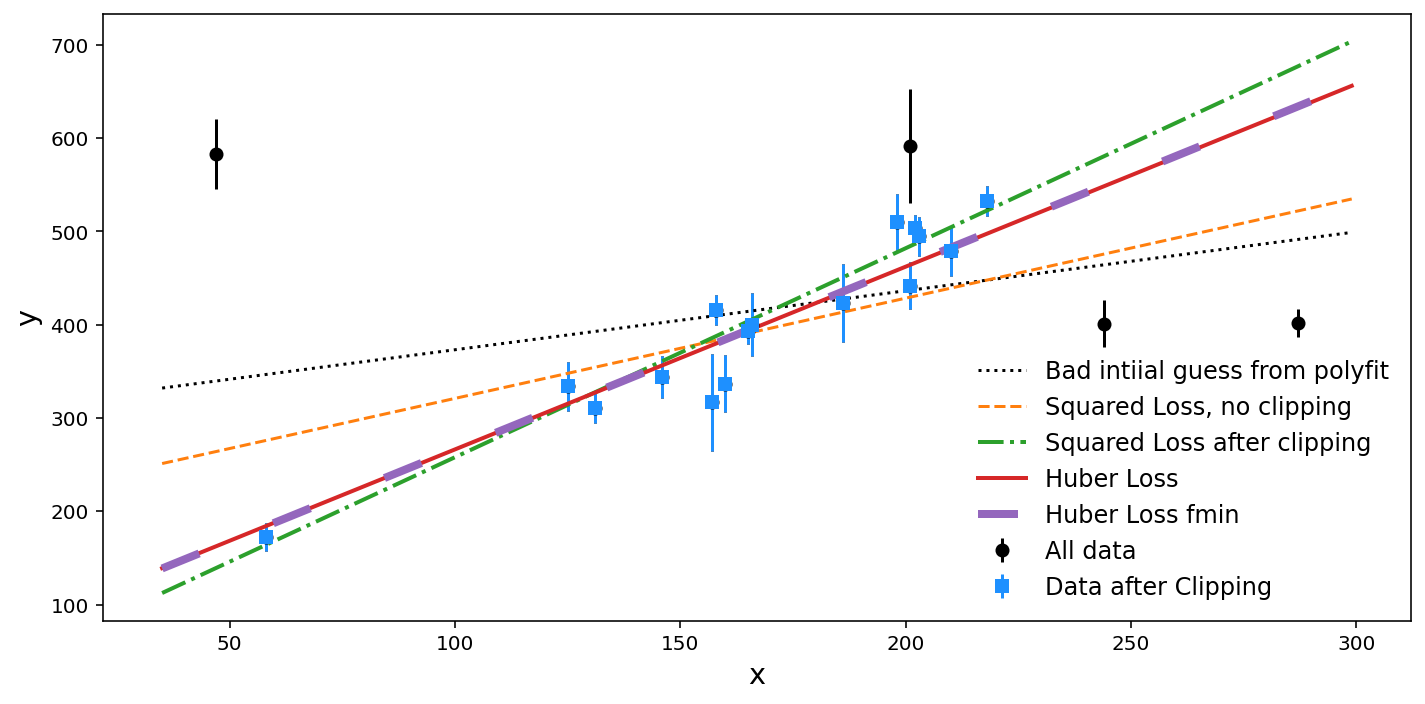

In [11]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

# plot the data
ax.errorbar(x, y, yerr=dy, color='k', marker='o', linestyle='None', label='All data')
ax.set_xlabel('x', fontsize='x-large')
ax.set_ylabel('y', fontsize='x-large')

# we need to overplot other lines on our plot 
x_range = np.array(ax.get_xlim())

# plot the bad initial guess
ax.plot(x_range, line(slope_guess, intercept_guess, x_range), color='k',\
        linestyle=':', label='Bad intiial guess from polyfit')

# call our function with the squared loss

a_ssr, b_ssr, loss_ssr, i_a_ssr, i_b_ssr = eval_loss_func(x, y, dy, a_range, b_range, squared_loss)
ax.plot(x_range, line(a_ssr, b_ssr, x_range), color='C1', linestyle='--', label='Squared Loss, no clipping')


# next I asked you to clean up the data and use whatever you like:
# you can use this commented out solution

# from astropy.visualization import hist as ahist
# from astropy.stats import sigma_clip
# ahist(residual_squared_loss, bins='scott')
# clipped = sigma_clip(residual_squared_loss, sigma=1.5, masked=True)
# keep = ~clipped.mask

# or you can recognize that I am lazy and it's just the first 4 points in your text file that are outliers...
keep = np.ones(len(x), dtype='bool')
keep[0:4] = False

# lets highlight the data after clipping
ax.errorbar(x[keep], y[keep], yerr=dy[keep], color='DodgerBlue',\
            marker='s', linestyle='None', label='Data after Clipping')


# now we evaluate the same loss function on the clipped data
a_ssr_c, b_ssr_c, loss_ssr_c, i_a_ssr_c, i_b_ssr_c =\
    eval_loss_func(x[keep], y[keep], dy[keep], a_range, b_range, squared_loss)
ax.plot(x_range, line(a_ssr_c, b_ssr_c, x_range), color='C2', linestyle='-.', label='Squared Loss after clipping', lw=2)


# and then with the Huber loss
a_huber, b_huber, loss_huber, i_a_huber, i_b_huber = eval_loss_func(x, y, dy, a_range, b_range, huber_loss)
ax.plot(x_range, line(a_huber, b_huber, x_range), color='C3', linestyle='-', label='Huber Loss', lw=2)

# technically, I said evaluate the Huber loss with scipy.optimize.fmin
# this is just to get you used to using an optimizer rather than a grid
# and to force you to define a function that you can reuse with the first argument being an array
# Define the Huber loss function... again
def huber_loss2(theta, x, y, dy, delta):
    a = theta[0]
    b = theta[1]
    z = zres(a, b, x, y, dy)
    zabs = np.abs(z)
    loss = zabs*0.
    ind_out = (zabs > delta)
    loss[ind_out] = delta*zabs[ind_out] - delta**2./2.
    loss[~ind_out] = z[~ind_out]**2./2
    return np.sum(loss)

theta  = scipy.optimize.fmin(huber_loss2, [slope_guess, intercept_guess], args=(x, y, dy, 1.), )
a_huber2, b_huber2 = theta
ax.plot(x_range, line(a_huber2, b_huber2, x_range), color='C4', linestyle=(0, (5, 10)), label='Huber Loss fmin', lw=4)

ax.legend(frameon=False, fontsize='large')
fig.tight_layout()

## Example 2: Optimal Photometry

We now turn to examples of applications of ML in astronomy. 

We'll look at two cases: simple photometry and simultaneous fitting of galaxy size and total flux.

Last week, I had you download a bunch of SDSS data files and plot `MAG_PSF` from them?
But what is this quantitiy and where the heck did it come from?

Have a look at one of the example images we saw as an example of astronomical data

In [12]:
### OPTIONAL: RUN THIS CELL 
# ! ds9 -scale zscale data/wdd7.071117_0328.073_6.sw.fits

# this was just to show that in our simulated source looks like real sources in the image

## A star and a point spread function

The stars in those images are not point sources, despite being trillions of kilometers from us. This is because as the light from the stars meet travel to meet their fate on our CCD detectors here on Earth, it gets spread out from a perfect point.

The **Point Spread Function** (the "PSF") is comprised of various contributions: from minute misalignments in the optics, to jitter in the tracking, to diffraction from the spider, to diffusion of the electrons as they travel through the silicon in the CCD ("charge diffusion"), to the homogenization of the PSF due to the refraction and diffraction in the atmosphere.  

The dominant effect is the one ***from the atmosphere***.

![PSF Formation](figures/psf-formation.jpg)

In practice, we don't construct the PSF from *ab initio* considerations because it's impractical to track each of these effects separately.

Instead, we measure it by looking at the observed shape of bright, isolated, point sources (i.e., stars). Those observations are noisy, so we fit analytical profiles to estimate the true PSF.

For simplicity, we will use just a single bivariate Gaussian here.

This is our model.



As before, we'll generate some data - but not for 1000s of sources. Just one. It'll be stored in a variable named `image`
You can see the true parameters of the image 

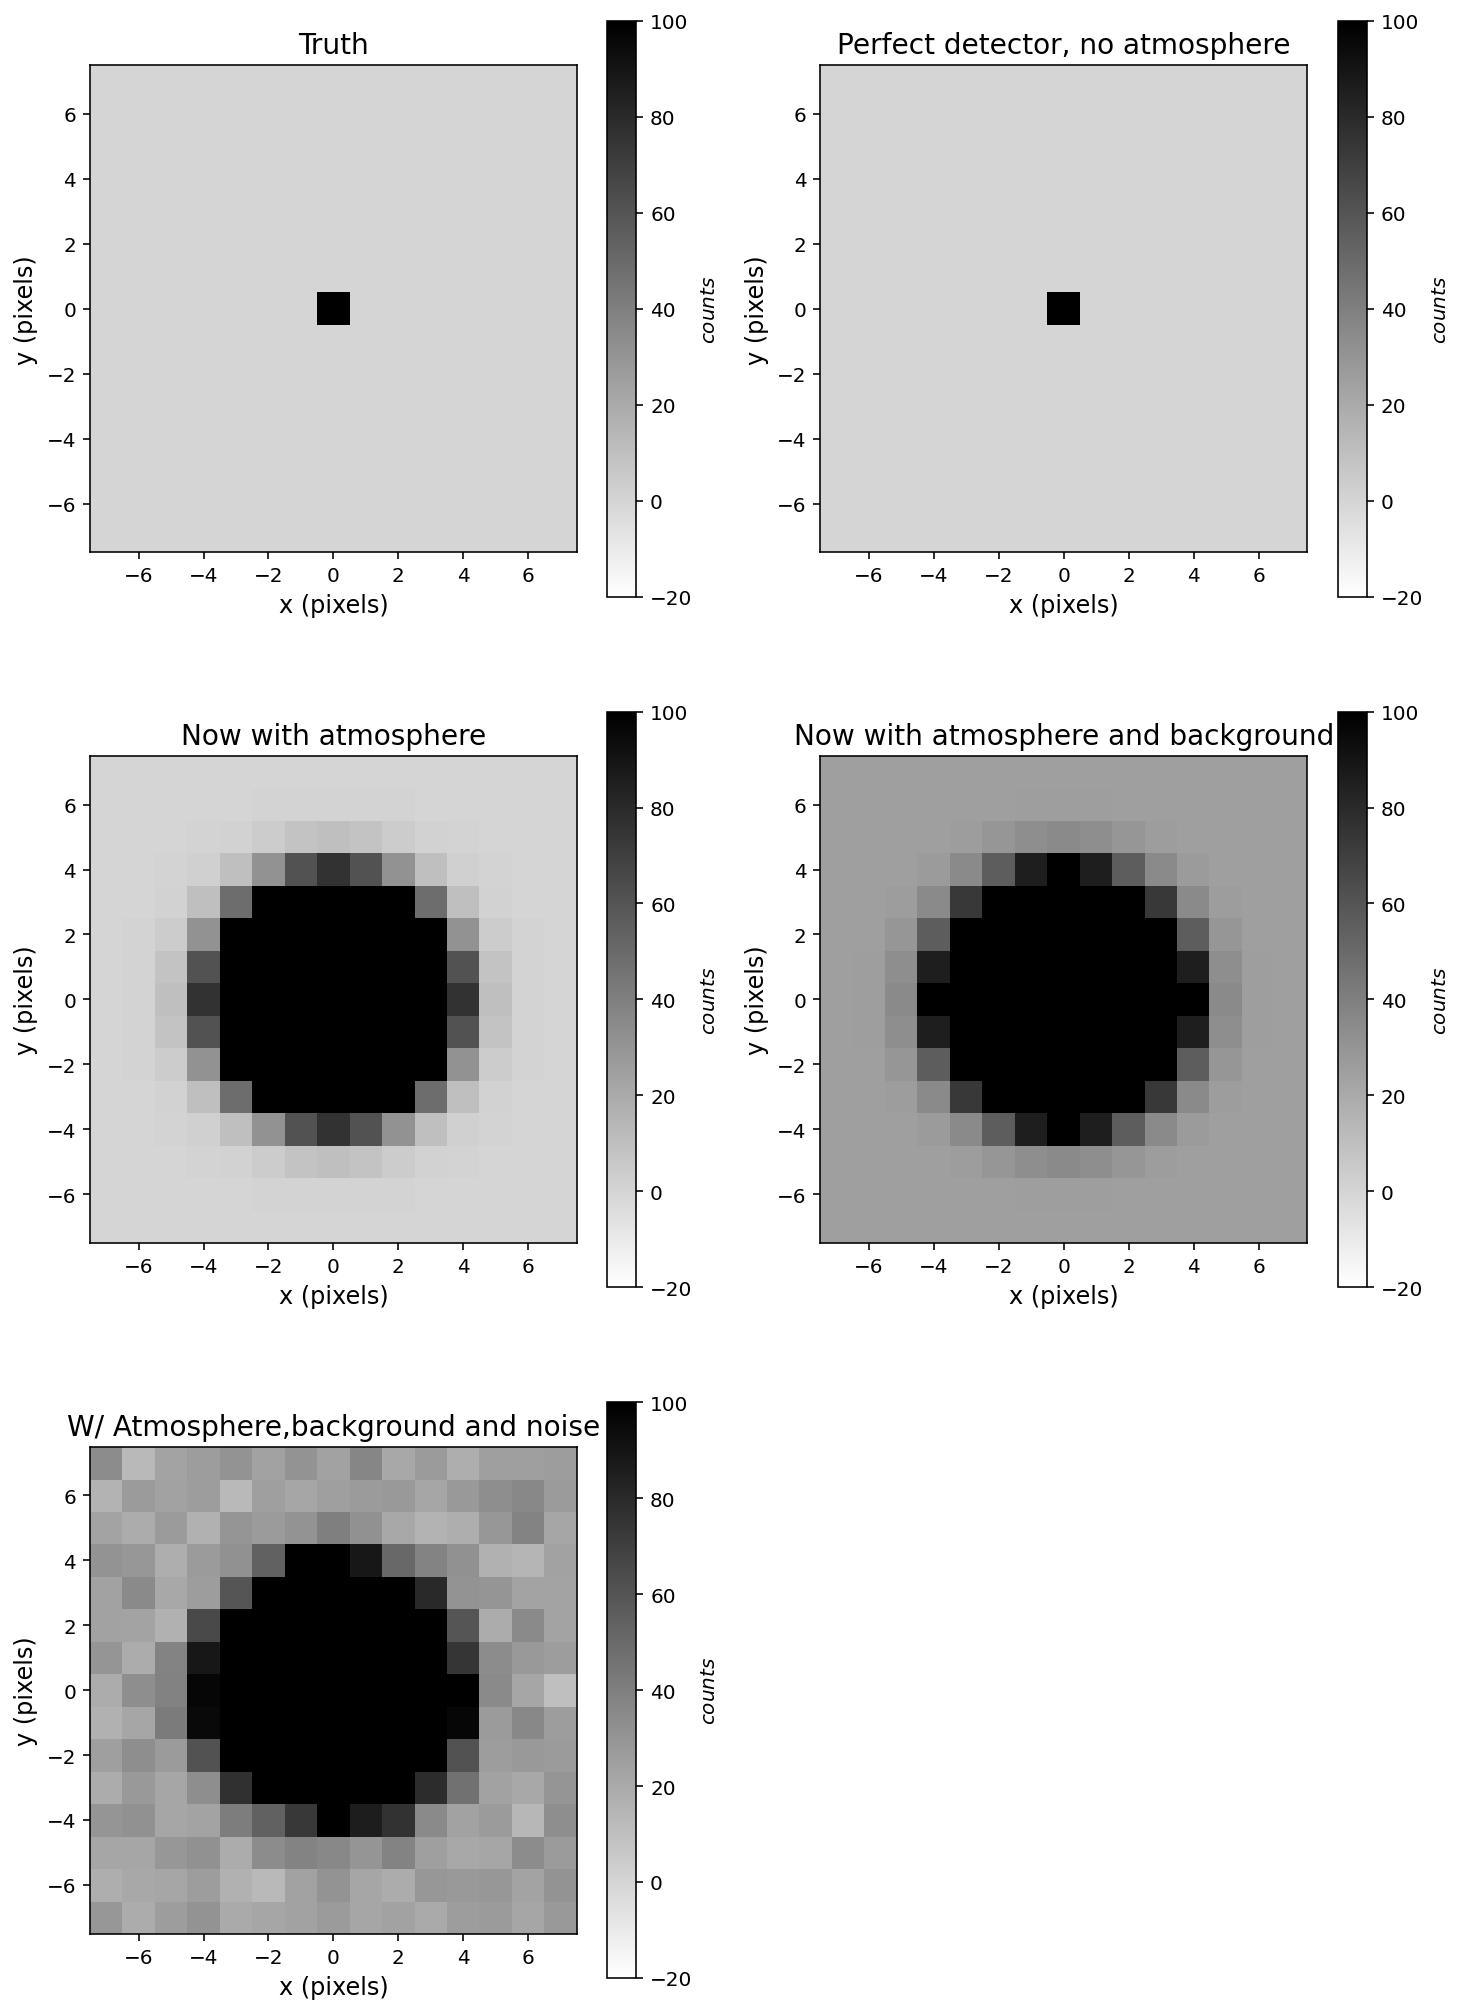

In [12]:
# DO NOT ALTER THIS CODE:
import numpy as np
import math
import matplotlib.pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev
np.random.seed(seed=42)

def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] / 2.

    if title is None:
        title = "min = %.0f, max=%.0f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect=1)
    plt.clim(-20, 100)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)


# These will be the parameters of our image:

Atrue = 10000.0    # the source count normalization
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 25        # sky background


def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./(sigmaPSF**2.)) / (np.sqrt(2.*math.pi)*sigmaPSF)
    return psf

fig = plt.figure(figsize=(12,18))

# uniform flux
image = np.zeros((xdim, ydim))
image[7,7] = Atrue
plotCutout(image, loc=321, fig=fig, title="Truth")

# random Poisson process
image = np.zeros((xdim, ydim))
image[7,7] = np.random.poisson(Atrue)
plotCutout(image, loc=322, fig=fig, title="Perfect detector, no atmosphere")

# PSF 
image = np.zeros((xdim, ydim))
image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
plotCutout(image, loc=323, fig=fig, title="Now with atmosphere")

# PSF with background
image += skyBg
plotCutout(image, loc=324, fig=fig, title="Now with atmosphere and background")

# PSF with background and noise
image = np.random.poisson(image)
plotCutout(image, loc=325, fig=fig, title="W/ Atmosphere,background and noise")

simulatedImage = image

## Photometry (measuring the flux)

We now have an image that we observe, and some ***understanding of the processes that created it***.
We have encoded that understanding into a model.
This means you can now use maximum likelihood to estimate the parameters of the underlying source - like the total area under the profile - a measurement of how much light we received from the source, or it's `FLUX`

The `MAG_PSF` you plotted from the SDSS HLC files last week is directly related to the flux by $-2.5*log_{10}(\text{Flux}) + \text{Constant}$

## PSF Photometry: A Maximum Likelihood estimation of the flux

So our **model** for the image is that it consists of a Gaussian with a flux normalization fo $A$ , plus the background (which we've removed), plus the Gaussian noise (caused by photon quantization).

So, <u>**once the background is removed**</u>, for ***each pixel*** I can write:

>$ I(x,y) = A * PSF(x - x_0, y - y_0) + r_i $

where $A$ is the flux of the star (i.e. the thing we want), and $r_i$ is drawn from a Gaussian with

>$N(0, \sigma_{x,y} = \sqrt{I_{x,y} + B})$

and $B$ is the sky background. It's critical not to forget the background when computing the sigma -- for faint sources, this is where most of the measurement uncertainty comes from!

### For a single pixel 

### $$
\begin{align}
p(I(x_i, y_i)|A, PSF(x_i-x_0, y_i-y_0), \sigma) &= N(I(x_i, y_i) - A*PSF(x_0, y_0)|\sigma) \\
& = \frac{1}{\sqrt{2 \pi \sigma^2}} A\exp \left( - \frac{(I(x_i, y_i) - A*PSF(x_0, y_0))^2}{2 \sigma^2} \right) 
\end{align}
$$

### For a whole image then $p1 \times p2 \times p3$....

### $$ 
\begin{align}
P &= \Gamma p(I(x, y)|A, PSF(x_i-x_0, y_i-y_0), \sigma) \\
& = N(I(x_i, y_i) - A*PSF(x_0, y_0)|\sigma) \\
& = \frac{1}{\sqrt{2 \pi \sigma^2}} A\exp \left( - \frac{(I(x_i, y_i) - A*PSF(x_0, y_0))^2}{2 \sigma^2} \right) 
\end{align}
$$

Note this is practically identical to our case with fitting a line, except that instead of having one index $i$, we have two indices for the data points, $(x, y)$. And ***each pixel*** is an independent data point that constrains our model.

So we can readily write out the log-likelihood as:

### $$\ln{L} = \text{constant} - \sum_{i=1}^N \frac{\left(I(x_i,y_i) - A\  \mathrm{PSF}(x_0,y_0)\right)^2}{2 \sigma^2}$$

Expanding:

## $$ \ln L(A) = C + \sum_{x,y} \frac{I_{x,y} A \cdot PSF(x - x_0, y - y_0)}{\sigma_{x,y}^2} - \sum_{x,y} \frac{A^2 \cdot PSF(x - x_0, y - y_0)^2}{2 \sigma_{x,y}^2}$$

where the $I^2$ term can just be absorbed into to the constant.

If we set 
## $$\phi_{x,y} = \sum_{x,y} \frac{I_{x,y} \cdot PSF_{x,y}}{\sigma_{x,y}^2}$$

and 
## $$\psi_{x,y} = \sum_{x,y} \frac{PSF_{x,y}^2}{\sigma_{x,y}^2}$$

then

## $$ \ln L(A) = C + A\cdot\phi_{x,y} - A^2\cdot \frac{\psi_{x,y}}{2} $$

As we've seen , maximizing the likelihood of a product of normal distribution reduces to minimizing the $\chi^2$, which is what you'll do next.

## Q2.1 Assume the noise is constant, and minimize the log-likelihood analytically. 
(i.e. some calculus required)

Looking at the form of $\phi_{x,y}$ and considering it for each pixel **what does it represent?**

## A2.1

The maximum likelihood solution for A is:

## $$ \frac{\partial ln L(A) }{\partial A} =   \phi_{x,y} - A \cdot \psi_{x,y} = 0 $$ 

## $$A_{ML} = \frac{\phi}{\psi}$$



and there: 
## $$ \ln L(A_{ML}) =  \frac{\phi^2}{2\psi}$$


Looking at the structure of:

## $$\phi_{x,y} \equiv \frac{1}{\sigma^2} I_{x,y} \otimes PSF(x, y)$$

this means that peaks in the likelihood are given by peaks in the image **convolved with the PSF**.


The height of these peaks is also this convolution normalized by the size of the PSF squared - i.e. the brightness of the source.


## Q2.2 Estimating the true flux

To estimate the true flux, we need to maximize the likelihood. That is equivalent to minimizing the $\chi^2$. As a reminder, our basic model is:

>$ I(x,y) = A * PSF(x - x_0, y - y_0) + r_i $


* estimate the background in the image
* estimate the noise in our measurements (remember it's a Poisson process!)
* as with the straight line estimate the true flux grid of A
* Destermine the chi-sq/DoF at each location on the A grid and plot it
* Compare the numerical estimate with your analytical estimate that you made with your answer to Q2.1

## A2.2

In [14]:
# notice that we are assuming that we have simgaPSF, so the PSF shape never changes
psf =  makePSF(image.shape, 0, 0, sigmaPSF)

def model(A, B):
    global psf    
    return A * psf + B

# before we define Chi-Squared we need the measurement error in the image
# recognizing that CCD counts are a Poisson process, which has variance = mean = lambda

variance = image
# note the model defintion in 2.1 didn't include the background but it is in included in the `image` variable
# i.e. don't add it again - you'll double count

# the number of degrees of freedom is a poorly defined concept in reality 
# for our purposes though, we have as many measurements there are in the image (that's the sample)
# and we're going to try and estimate two parameters - flux and background
ndof = image.size - 2

In [15]:
# next we need reasonable ranges for the flux and background
# we know that the flux and background have to be positive
a_range = np.arange(np.median(image), image.max()*10.)
b_range = np.arange(np.median(image)/10., np.median(image)*10.)
a, b = np.meshgrid(a_range, b_range)

In [16]:
# personally, I'm already bored writing for loops to iterate the same function over locations on a grid
# in principle, all our chisq needs to do is to take a vector of A, B and return a loss surface
# while python is dynamically typed, we know we're going to pass floating point variables 
# and then return a floating point grid
# Much of the slowness is just that the language is compiled at runtime
# and has to be able to handle dynamic typing

# if we can force the use of floats, we could pre-compile a bit of code to run at native machine speeds
# this is what numba does
# Numba is a just-in-time compiler for Python and has a bunch of decorators 
# it'll be useful many times this semester
#
# Try it out: 
#
# https://numba.pydata.org/numba-doc/dev/user/5minguide.html

import numba
from numba import vectorize, float64, jit

In [17]:
# this is a decorator to an otherwise vanilla python function that says take two floats and return a float
@vectorize([float64(float64, float64)])
def chisqr(A, B):
    global image
    global variance
    global psf
    global ndof
    residual = (image - (A*psf + B))
    chisqr   = np.sum( (residual**2)/variance )
    return chisqr/ndof

print("Grid size:", a.size)

# and then evaluate the surface over the entire grid of A and B!
%time chisqr_surface = chisqr(a, b)

# while numpy and Numba mostly work nice, there's a few gotchas
# See 1.18.1.4 in the FAQ https://numba.pydata.org/numba-doc/dev/user/faq.html
# for array ordering
# the upshot is that we need to take a transpose
chisqr_surface = chisqr_surface.T

Grid size: 8108100
CPU times: user 25.6 s, sys: 648 ms, total: 26.3 s
Wall time: 27.3 s


In [18]:
# the minimum loss is at 
imin = chisqr_surface.argmin()
# that's going to give you a single index for a flat array, but you can get the index in both dimensions easily
i_a, i_b =np.unravel_index(imin, chisqr_surface.shape)
print(f"Grid Search Estimate of Flux, Background at min ChiSq/DoF= {a_range[i_a]}, {b_range[i_b]} {chisqr_surface.min()}")
print(f"Truth for Flux, Background = {Atrue}, {skyBg}")


phi = np.sum((image - skyBg)*psf/variance)
psi = np.sum(psf*psf/variance)

print(f"Analytic MLE for Flux = {phi/psi}")

Grid Search Estimate of Flux, Background at min ChiSq/DoF= 10076.0, 23.0 1.2549461897773257
Truth for Flux, Background = 10000.0, 25
Analytic MLE for Flux = 10039.385191367875


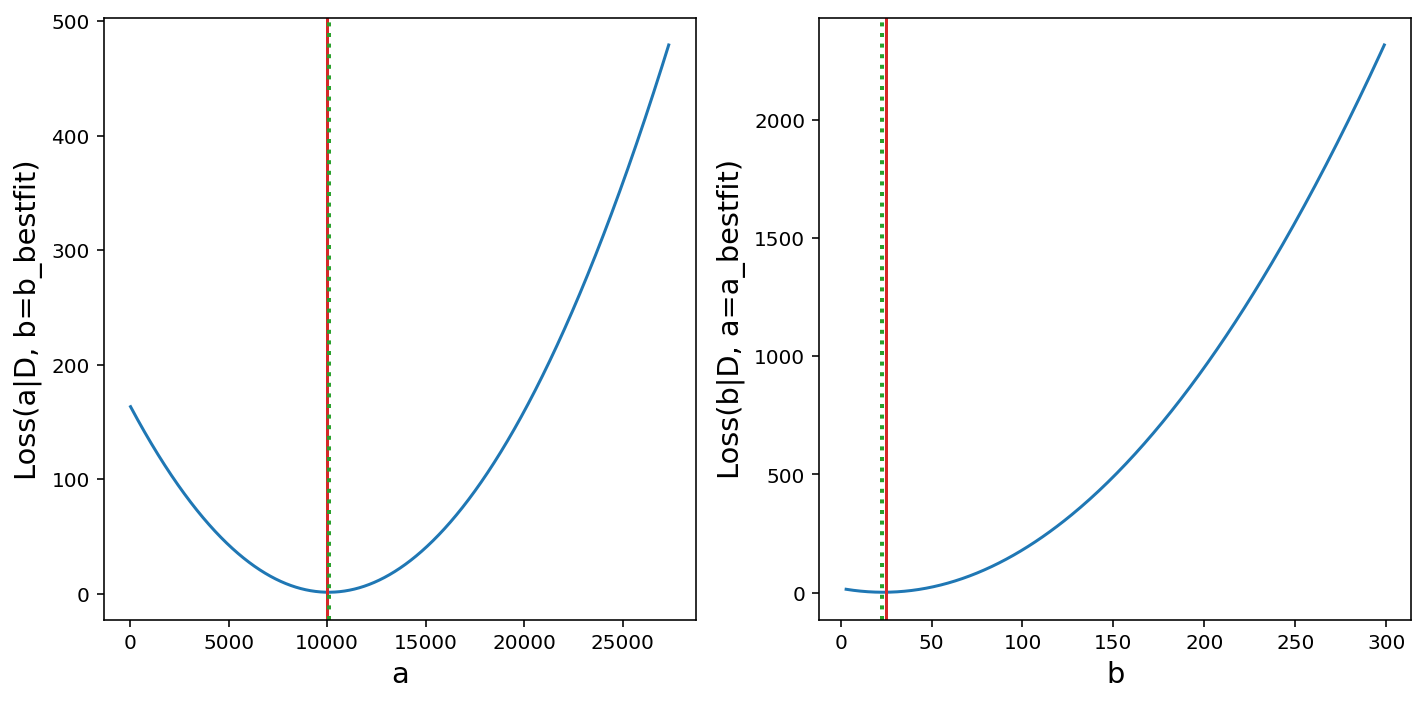

In [20]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


# we already known the MLE values, so we simply look at the marginal likelihood at that location
ax1.plot(a_range, chisqr_surface[:, i_b], color='C0')
ax2.plot(b_range, chisqr_surface[i_a, :], color='C0')
ax1.axvline(Atrue, linestyle='-', color='C3')
ax1.axvline(a_range[i_a], linestyle=':', color='C2', lw=2)
ax2.axvline(skyBg, linestyle='-', color='C3')
ax2.axvline(b_range[i_b], linestyle=':', color='C2', lw=2)


ax1.set_xlabel('a', fontsize='x-large')
ax2.set_xlabel('b', fontsize='x-large')
ax1.set_ylabel('Loss(a|D, b=b_bestfit)', fontsize='x-large')
ax2.set_ylabel('Loss(b|D, a=a_bestfit)', fontsize='x-large')

fig.tight_layout()

In [21]:
# if you get very bored, you can try it the other way.
# like so - factor of ~20 difference...

def old_chisqr(A, B):
    global image
    global variance
    global psf
    residual = (image - (A*psf + B))
    chisqr   = np.sum((residual**2)/variance)
    return chisqr/ndof

def doit():
    loss = np.ones((len(a_range), len(b_range)))
    for i, t_a in enumerate(a_range):
        for j, t_b in enumerate(b_range):
            loss[i][j] = old_chisqr(t_a, t_b)
    return loss

%time old_chisqr = doit()     

CPU times: user 5min 28s, sys: 9.7 s, total: 5min 37s
Wall time: 5min 54s


## Models with more parameters

The iterative example above is a bit contrived as we can, and did, solve the MLE analytically 

It has the benefit of being general, however. We can apply the same technique to models with more parameters (within the limits of computing power available to us!). The other parameters could be the position of the object ($x$, $y$), or some measure of the shape of the object.

As the number of parameters increases, the likelihood curve from the previous slide becomes the ***likelihood (hyper)surface***. The more dimensions there are, the more difficult (computationally expensive) it becomes to find its maximum using brute force solutions; even for 2D cases, we're likely to resort to ***minimization algorithms*** (e.g., Levenberg–Marquardt or others).

## Q3: Measuring the size and brightness of a spherical, gaussian, galaxy

In Homework 1, you had `MAG_PSF` not just for stars, but also for galaxies. 

Even in the ideal (space) case, the Galaxy will not be a point source. We'll imagine we're dealing with a "Gaussian spherical galaxy" -- i.e., one whose intensity  falls of as a 2D gaussian would. As with the star, we'll asume the position of the galaxy is known.

Our model has two parameters: the measure of the extendedness of the galaxy -- $\sigma$ -- and its total flux, $C$:

>$ I(x, y) = \frac{C}{2 \pi \sigma^2} \exp \left( -\frac{(x-x_0)^2 + (y-y_0)^2}{2\sigma^2} \right) $

We will now have to explore the likelihood surface in $(C, \sigma)$ space, and find the point of its maximum.

Note #2: When generating the simulated image, $I(x, y)$ needs to be ***convolved*** with the PSF. Fortunately (actually, because I'm lazy) we've chosen the galaxy profile to be gaussian, and the convolution of two gaussians with variances $\sigma_1^2$ and $\sigma_2^2$ is also a gaussian with the variance $\sigma_1^2 + \sigma_2^2$ (i.e., it's wider). 

Our function `gauss2D` utilizes this fact to generate the convolved image of the galaxy.

* we will generate two cases with `gauss2D` below:
* using this image as your data evaluate the log-likelihood
    * in Q2, we only did this for the flux $A$
    * now you have two parameters $C$ and it's shape $\sigma$
    * evaluate the likelihood on this grid 
    
    `C = np.linspace(500, 1500, 101)`
    
    `Sigma = np.linspace(0, 2.5, 101)`
    
* plot your estimated log-likehood surface

In [29]:
def gauss2D(muX, muY, sig, A, skyBg, sigPSF, Xpixels, Ypixels):
    """
    Generate an image of size (Xpixels, Ypixels) with
    a 2D circular Gaussian of total flux A
    with standard deviation sigma^2=sig^2 + sigPSF^2
    superimposed on a uniform background B and centered
    on (muX, muY).
    """
    r = np.sqrt((Xpixels-muX)**2 + (Ypixels-muY)**2)
    # make and set image to the background value
    image = np.empty(r.shape)
    image.fill(skyBg)

    ## now add circular gaussian profile (normalized to A)
    # source gauss convolved with single-gauss PSF  
    sigConvSquare = sig**2 + sigPSF**2
    image += A*np.exp(-r**2/2/sigConvSquare) / (2*math.pi*sigConvSquare)
    return image


def addnoise(inimage, sigNoise, sourceImage, addsourcenoise=0): 
    """Add gaussian noise to the image, and return the image and variance plane"""
    image = np.copy(inimage)
    image += np.random.normal(0, sigNoise, image.shape)
    variance = 0*image + sigNoise**2

    if (addsourcenoise):
        gain = 1.0  # as a reminder...
        sourceVariance = sourceImage/gain
        image += np.random.normal(0, np.sqrt(sourceVariance), image.shape)
        variance += sourceVariance

    return image, variance 


def simulate(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, sigmaNoise):
    # set seed
    np.random.seed(42)
    
    # define the (square) grid
    xpix = np.linspace(-7, 7, 15)

    ## make psf (sigtrue=0) 
    psf = gauss2D(muXtrue, muYtrue, 0, Atrue, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)

    ## make noiseless image (convolved with psf given by sigmaPSF, image size given by 1Dpixels) 
    nonoise = gauss2D(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)
 
    ## now add noise
    image, variance = addnoise(nonoise, sigmaNoise, 0) 

    ## difference object - psf
    diffimage = image - psf

    return nonoise, psf, image, diffimage


# Case 1 - a sanity check - if sigtrue (i.e. the shape of the galaxy) is 0 we're back to dealing with a single star.

In [30]:
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 
sigtrue = 0.0     # the intrinsic gaussian source width, sigma (in pixels) 
Atrue = 1000.0    # the source count normalization
skyBg = 25        # sky background
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
sigmaNoise = 5.0  # gaussian sigma for white noise (counts), e.g. due to sky 


nonoise, psf, image, diffimage = simulate(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, sigmaNoise)

## A3.1 - this time we'll assume we have sigPSF instead of the actual PSF shape. We'll also assume we have the background. We already showed we could optimize for that as well in Q2. In principle, we could also optimize muX, muY (the source centroid)

In [22]:
# I'm going to make the grid finer than what I told you to use just to show how useful the vectorize trick is

C_range = np.linspace(500, 1500, 1001)
Sigma_range = np.linspace(0, 2.5, 251)

C, Sigma = np.meshgrid(C_range, Sigma_range)

In [36]:
# we're given a few things
# we know the image size - in general this will be some fixed size cutout around a source
Xpixels = np.linspace(-7, 7, 15)
Ypixels = np.linspace(-7, 7, 15)
X, Y = np.meshgrid(Xpixels, Ypixels)

# we're also going to assume we know source centroid 
# in general, we do not know this, and we also optimize for these
muX = 0.
muY = 0.

r = np.sqrt((X - muX)**2 + (Y - muY)**2)

# we're assuming we know the PSF shape
# also something we need to optimize
sigPSF = 1.5

# we also know the number of degrees of freedom
ndof = image.size -2

In [37]:
# we define our chi-squared function - instead of changing the background like last time, we're changing PSF shape

def chisqr(flux, source_sig):
    # now we need a model of the image
    global sigPSF
    global r
    global ndof
    global skyBg
    global image
    variance = image.copy()

    sigConvSquare = source_sig**2 + sigPSF**2
    model = flux*np.exp(-r**2/2/sigConvSquare) / (2*math.pi*sigConvSquare) + skyBg
    
    residual = image - model
    chisqr   = np.sum( (residual**2.) / variance)
    return chisqr/ndof  

# like numba, numpy also has a vectorize - this also works to take scalar inputs and instead run on a vector
# this doesn't compile the code, and it's not really any more efficient than our loops, but
# it does make it easier to use with a moderate number of parameters, and because it's not compiled
# global variables can be changed and the function will operate
chisqr = np.vectorize(chisqr)

# note that global variables are a terrible way to actually do this
# I'm using them to introduce you to the concept of scope of variables and namespaces

In [38]:
# next lets define a plot 
def plotLikelihood(Sigma_range, C_range, likelihood, sigtrue, sigmaML, CmodML):
    """Plot the likelihood densities"""
    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(left=0.08, bottom=0.15, right=0.95, top=0.90, wspace=0.29, hspace=0.46)

    ## renormalize and truncate for clean plotting
    likelihood -= likelihood.min()


    ## likelihood image 
    ax = fig.add_axes([0.35, 0.35, 0.45, 0.6], xticks=[], yticks=[])
    ax.set_title('Likelihood image', fontsize=14)
    # pretty color map
    plt.imshow(likelihood, origin='lower', extent=(Sigma_range[0], Sigma_range[-1], C_range[0], \
                                            C_range[-1]), cmap=plt.cm.Blues, aspect='auto')

    # colorbar
    cax = plt.axes([0.82, 0.35, 0.02, 0.6])
    cb = plt.colorbar(cax=cax)
    cb.set_label(r'$likelihood(\sigma, C_{mod})$', fontsize=14)
    plt.clim(np.min(likelihood), np.max(likelihood))

    # mark true values     
    ax.plot(sigtrue, 1000.0, 'o', color='red', alpha=0.75)
    # mark ML solution: (sigmaML, CmodML)
    ax.plot(sigmaML, CmodML, 'x', color='white', alpha=0.99, lw=35)

    # marginal projections
    p_sigma = likelihood.sum(0)
    p_Cmod = likelihood.sum(1)
  
    ax1 = fig.add_axes([0.35, 0.1, 0.45, 0.23], yticks=[])
    ax1.plot(Sigma_range, p_sigma, '-k')
    ax1.set_xlabel(r'$\sigma$ (pixel)', fontsize=12)
    ax1.set_ylabel(r'$p(\sigma)$', fontsize=12)
    ax1.set_xlim(np.min(Sigma_range), np.max(Sigma_range))

    ax2 = fig.add_axes([0.15, 0.35, 0.18, 0.6], xticks=[])
    ax2.plot(p_Cmod, C_range, '-k')
    ax2.set_ylabel(r'$C_{mod}$ (counts)', fontsize=12)
    ax2.set_xlabel(r'$p(C_{mod})$', fontsize=12)
    ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse x axis
    ax2.set_ylim(np.min(C_range), np.max(C_range))

In [39]:
# because I'm really lazy, I'll make the evaluation also a function
def doit():

    chisqr_surface = chisqr(C, Sigma)
    likelihood = np.exp(-0.5*chisqr_surface.T)

    # the maxmium log likelihood is at 
    imax = likelihood.argmax()
    # that's going to give you a single index for a flat array, but you can get the index in both dimensions easily
    i_C, i_sig =np.unravel_index(imax, likelihood.shape)

    CmodML = C_range[i_C]
    sigmaML = Sigma_range[i_sig]
    plotLikelihood(Sigma_range, C_range, likelihood, sigtrue, sigmaML, CmodML)
    print(f'MLE parameters for flux, sigma = {CmodML:.2f}, {sigmaML:.2f}')

MLE parameters for flux, sigma = 980.00, 0.00


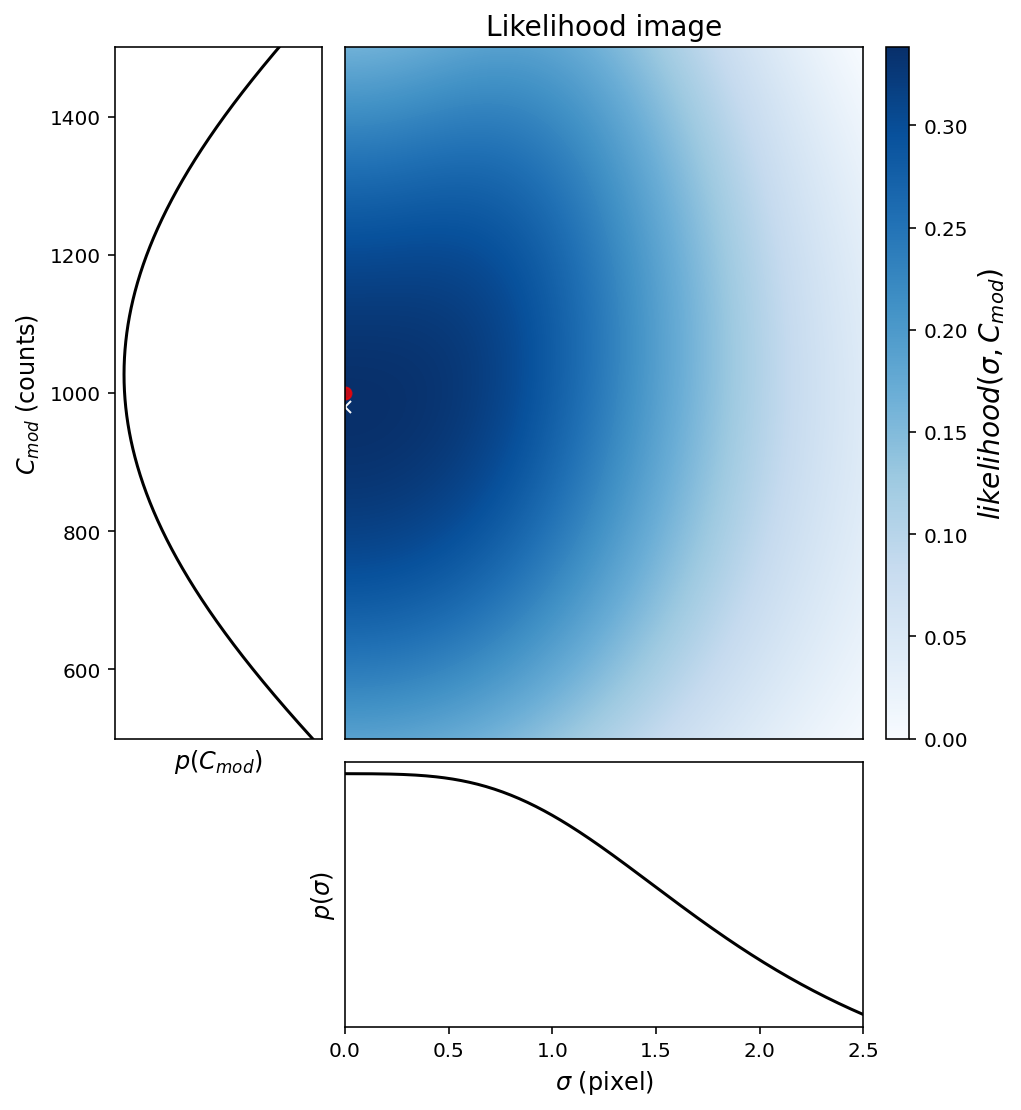

In [40]:
doit()

# Case 2 - if sigtrue is non-zero, we're dealing with a spherical cow galaxy

In [41]:
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 
sigtrue = 1.0     # the intrinsic gaussian source width, sigma (in pixels) 
Atrue = 1000.0    # the source count normalization
skyBg = 25        # sky background
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
sigmaNoise = 5.0  # gaussian sigma for white noise (counts), e.g. due to sky 

nonoise, psf, image, diffimage = simulate(muXtrue, muYtrue, sigtrue, Atrue, skyBg, sigmaPSF, sigmaNoise)

MLE parameters for flux, sigma = 919.00, 0.76


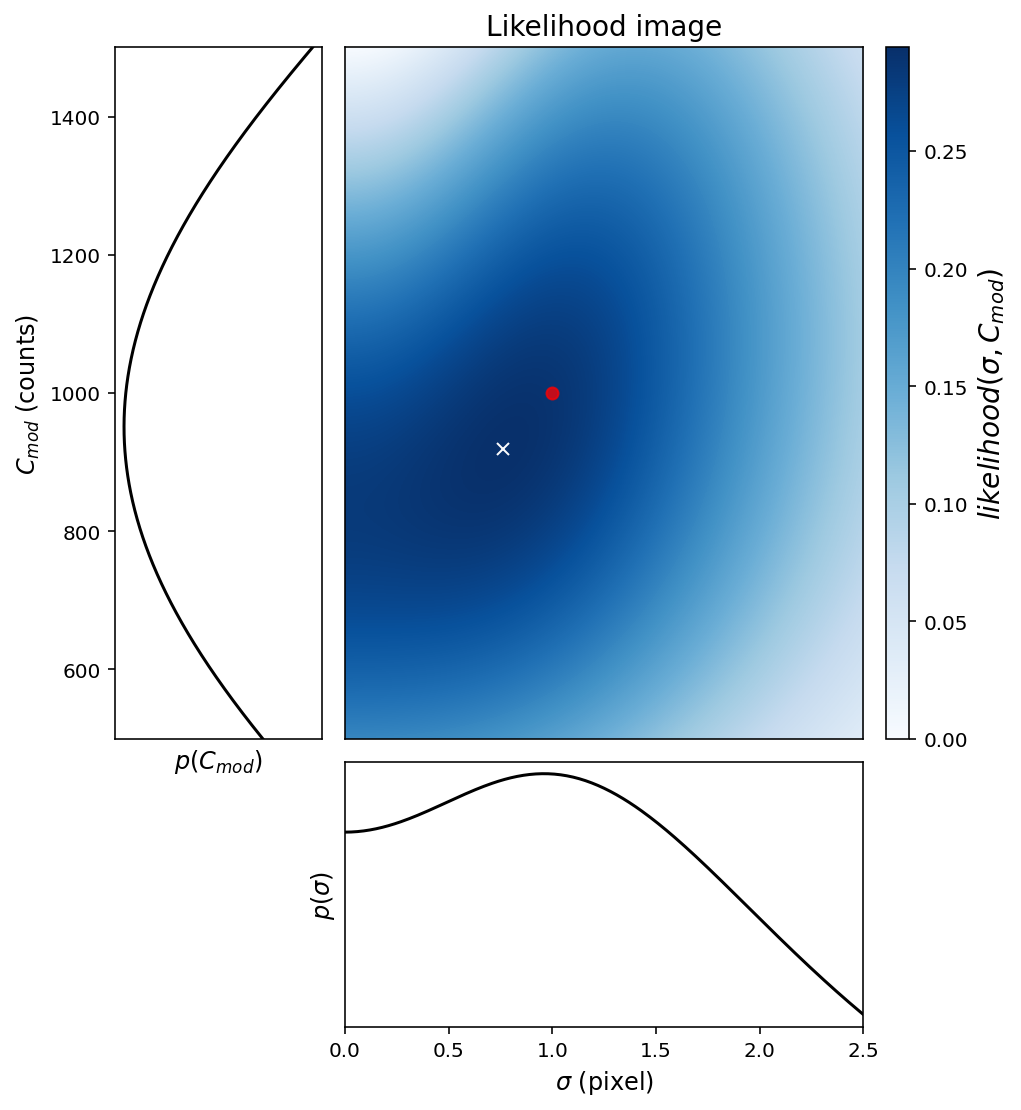

In [42]:
doit()

Every one of the measurements in the SDSS HLC files was estimated using a more sophisticated version of this process.